In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation
from scipy.sparse        import diags_array
from scipy.sparse.linalg import spsolve
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))
display(HTML(""" <style>.output_png { display: table-cell; text-align: center; vertical-align: middle; }</style> """))
display(HTML("<style> div.text_cell_render { line-height: 2.0; } </style>"))    # Adjust linespread

In [ ]:
# ** Set up a plotting function ** #

# THIS DOESNT PLOT AT t=0

def plotting(U, x, t, exact_handle):
    # grid spacing
    dx = x[1] - x[0]

    markers = ['x','s','d','+','o','.']
    colours = ['xkcd:salmon','xkcd:golden rod','xkcd:teal',
               'xkcd:purple','xkcd:slate','xkcd:silver']
    disp_times = [N//20, N//10, N//5, N//2, N]

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    ax.scatter([0], [0], color='white', label=r'Exact $u(x,t)$', lw=0)
    for i, idx_t in enumerate(disp_times):
        lbl = ('t = {0:.0e}'.format(t[idx_t])
               if 0 < t[idx_t] < T else
               't = {0:.0f}'.format(t[idx_t]))
        ax.plot(x, exact_handle(x, t[idx_t]),
                color=colours[i], label=lbl)

    ax.scatter([0], [0], color='white',
               label=r'Numerical $U(x,t)$', lw=0)
    for i, idx_t in enumerate(disp_times):
        lbl = ('t = {0:.0e}'.format(t[idx_t])
               if 0 < t[idx_t] < T else
               't = {0:.0f}'.format(t[idx_t]))
        ax.plot(x[::2], U[idx_t][::2],
                linestyle='', marker=markers[i],
                color=colours[i], label=lbl)

    ax.legend(ncols=2, loc='center',
              bbox_to_anchor=(1.2, 0.5), title='Comparison')
    # show full domain
    ax.set_xlim(x.min() - dx, x.max() + dx)
    plt.xlabel("Space (x)")
    plt.ylabel("Solution")
    plt.show()

In [32]:
def f(x):
    x0 = 0 
    epsilon = 0.05
    
    U0 = np.zeros_like(x)
    mask = np.abs(x - x0) <= epsilon
    U0[mask] = 1 / (2 * epsilon)  # I NEED HELP TO UNDERSTAND WHY I NEED THIS IN ORDER FOR THE SOLUTIONS TO ALIGN
    return U0

# Analytic Solution
def U_exact(x, t, D=1):
    if t < 1e-10:
        return f(x)
    
    u_exact = 1.0 / (2 * np.sqrt(np.pi * D * t)) * np.exp(-x**2 / (4 * D * t))
    
    return u_exact

In [33]:
# ** Set parameters ** #
N = 200      # number of timesteps
T = 1      # final time 
t = np.linspace(0, T, 201)      # Time grid

M = 100    # number of spaces in x
x = np.linspace(-2, 2, M + 1)    # Space grid

dx = x[1] - x[0] 
dt = t[1] - t[0]

C = dt/(dx**2)
print('dx = {0:.2e}, dt = {1:.2e}, C = {2}'.format(dx, dt, C))

dx = 4.00e-02, dt = 5.00e-03, C = 3.1249999999999942


In [34]:
# Store data in sparse format to prevent the memory allocation of M² - M + 2 zeros

# Values on the three non-zero diagonals
diags = np.ones((3,M+1))

# Add 2C to main diagonal (first index = 0 represents the main diagonal here)
diags[0] += 2 * C             

# The upper and lower diagonals are -C except in the first/last row, which we will deal with next
diags[1:] = - C;    

# Fix the upper diagonal in the first row (the first entry should be -2C)
diags[1,0] = - 2*C

# Fix the lower diagonal in the last row (the penultimate entry should be -2C - the last is ignored when making A)
diags[2,-2] = -2*C

# Create the matrix, taking care of the order in which we defined the diagonals
# format = 'csr' defines a sparse matrix
A = diags_array(diags, offsets = (0,1,-1), shape = (M+1, M+1), format = 'csr')

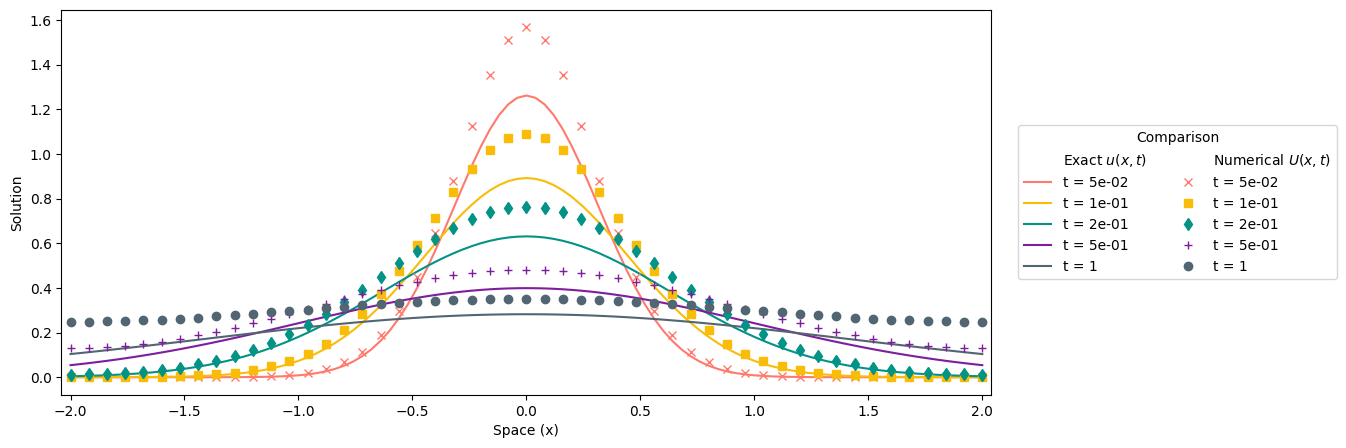

In [35]:
# ** Initialize output ** #

# Preallocate the numerical solution in a matrix: the first dimension is time and the second is space; i.e., each row corresponds to a timestep
U = np.zeros((N+1,M+1))
U[0] = f(x)

# Also store numerical solution
U_ex = np.zeros((N+1,M+1))

# ** Iterate ** #
for n in range(0, N):
    # Solve linear system instead of computing the inverse: computing the inverse is expensive and numerically instable 
    # SciPy has a subroutine for sparse matrices, but if you want to stick to NumPy, you can instead use: np.linalg.solve(A.toarray(),U[0])
    U[n+1] = spsolve(A, U[n])
    U_ex[n] = U_exact(x,t[n])
    
U_ex[n+1] = U_exact(x,t[n+1])

# Feel free to compare the solution as in the first bit of the notebook:
plotting(U,x,t, U_exact)

In [211]:
# perform on an infiite domain

# log y axis 

# Explain how the dirac delta has one point creating inacuracy 

In [238]:
def animate(i):
    l.set_data(x,      U[i])
    m.set_data(x[::2], U_ex[i][::2])
    return l, m

fig, ax = plt.subplots()
# compute grid spacing
dx = x[1] - x[0]
# use full domain on x
ax.axis([x.min() - dx,
         x.max() + dx,
         0 - 1e-2,
         U_ex.max() + 1e-2])
l, = ax.plot([], [], '-',  color='xkcd:slate',   linewidth=2)
m, = ax.plot([], [], '--', color='xkcd:salmon', marker='x')
ani = matplotlib.animation.FuncAnimation(fig, animate,
                                         frames=N+1,
                                         interval=50,
                                         blit=True)
plt.close(fig)
HTML(ani.to_jshtml())